In [3]:
from pyts.datasets import load_gunpoint
import matplotlib.pyplot as plt
import numpy as np
import mass_ts as mts

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.metrics import f1_score

import scipy.stats as sps

import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.special import entr

/Users/stefan-temp/Desktop/General/Privat/greedy-shapelet-search/venv-hyp-mar/lib/python3.9/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


In [4]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [26]:
%%time

class ShapeletTransform():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        # Window the array
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
        distances = []
        for sample_candidates in windowed_data:
            candidate_distances = np.array([((windowed_data - candidate)**2).sum(axis=-1).min(axis=-1) for candidate in sample_candidates])
            distances.append(candidate_distances)
        return np.stack(distances)
        # print(np.stack(distances).shape)
        # return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])
    

    def get_top_k_shapelets(self, X_train, y_train, n_shapelets=1, shapelet_min_size = 10, shapelet_max_size=20):

        top_shapelets = []
        for shapelet_size in range(shapelet_min_size,shapelet_max_size):
            self.main_event_loop(X_train, y_train, n_shapelets, shapelet_size)
            top_shapelets.extend([(sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size) for sample_idx, candidate_idx, info_gain, margin, shapelet in self.top_shapelets])
        self.shapelets = top_shapelets
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)

        self.exclusion_zone = {}
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, shapelet, shapelet_size))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets




    def main_event_loop(self, X_train, y_train, n_shapelets=1, shapelet_size = 10):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Store shapelet size
        self.shapelet_size = shapelet_size
        # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
        profiles = self.get_candidate_mins(X_train, shapelet_size)
        # Extract a shapelet for n_shapelets
        self.extract_shapelets(profiles, X_train, y_train)
        # Sort shapelets according to info gain descending
        self.shapelets.sort(key=lambda x: (x[2],x[3]), reverse=True)
        # Retrieve top shapelets
        self.retrieve_top_shapelets(X_train, n_shapelets)


    def retrieve_top_shapelets(self, X_train, n_shapelets):
        # Apply exclusion zone and selecting the top n_shapelets
        top_shapelets = []
        n_shapelets_found = 0
        self.exclusion_zone = {}
        # Iterate over all shapelet candidates
        for sample_idx, candidate_idx, info_gain, margin in self.shapelets:
            # If the correct number of shapelets was found, break out of loop
            if n_shapelets_found == n_shapelets:
                break
            # Check if sample index of candidate in exclusion zone samples
            if sample_idx not in self.exclusion_zone.keys():
                self.exclusion_zone[sample_idx] = []
            else:
                # Otherwise check if candidate index is in exclusion zone of sample
                if candidate_idx in self.exclusion_zone[sample_idx]:
                    continue
            self.exclusion_zone[sample_idx].extend(list(range(candidate_idx - self.shapelet_size, candidate_idx+self.shapelet_size)))
            top_shapelets.append((sample_idx, candidate_idx, info_gain, margin, X_train[sample_idx,candidate_idx:candidate_idx+self.shapelet_size]))
            n_shapelets_found += 1
        self.top_shapelets = top_shapelets

    def extract_shapelets(self, profiles, X_train, y_train):
        """
        Extracts a (greedy) optimal shapelet.
        """
        # Iterate through all samples in profiles
        for sample_idx in range(profiles.shape[0]):
            # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
            sample = profiles[sample_idx]
            # Iterate through all candidate distances of the given sample
            for candidate_idx in range(sample.shape[0]):
                # The minimum distances of a candidate to all other samples
                candidate = sample[candidate_idx,:]
                # Score candidate
                info_gain, margin = self.calculate_infogain(candidate.reshape((50,1)), y_train)
                self.shapelets.append((sample_idx, candidate_idx, info_gain, margin))
                

    def calculate_infogain(self, candidate, y_train):
        """
        Given a 1-d array, calculates the infogain according the labels y_train.
        """
        # Initialize decision tree classifier
        clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1)
        # Fit decision tree
        clf.fit(candidate, y_train)
        # Get entropy before best split
        entropy_before = clf.tree_.impurity[0]
        # Get entropy after best split
        entropy_after = clf.tree_.value.sum(-1)[1]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[1] + \
            clf.tree_.value.sum(-1)[2]/clf.tree_.value.sum(-1)[0] * clf.tree_.impurity[2]

        # Calculate margin
        if len(set(y_train)) != 2:
            print(f"There is something wrong with the number of labels! The number o labels is {len(set(y_train))}.")
            raise ValueError
        label_avgs = [candidate[y_train==label].mean() for label in set(y_train)]
        margin = abs(label_avgs[0]-label_avgs[1])
        # Return information gain
        return entropy_before - entropy_after, margin

    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """
        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        """
        Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
        """
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        """
        Transformation pipeline for a new dataset X
        """
        # Retrieve all shapelets
        shapelets = np.array([shapelet[3] for shapelet in self.top_shapelets])
        # Standardize the shapelets
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        # Window the data
        windowed_test = self.rolling_window(X, window=self.shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        # Calculate the features (get min shapelet distances of all shapelets to all samples)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

ST = ShapeletTransform()
# ST.main_event_loop(X_train, y_train, n_shapelets=5, shapelet_size=38)
ST.get_top_k_shapelets(X_train, y_train, n_shapelets=10, shapelet_min_size = 30, shapelet_max_size=40)

CPU times: user 57 s, sys: 8.53 s, total: 1min 5s
Wall time: 1min 5s


In [8]:
ST.top_shapelets

[(8,
  105,
  array([0.99884554]),
  31.226651089786735,
  array([-0.95079668, -1.025098  , -1.0767507 , -1.107045  , -1.1150216 ,
         -1.1150928 , -1.1104016 , -1.0952914 , -1.0770713 , -1.0687018 ,
         -1.0613745 , -1.0540497 , -1.0526052 , -1.0526178 , -1.0475158 ,
         -1.0476689 , -1.0467752 , -1.0454486 , -1.0467271 , -1.0453529 ,
         -1.0457445 , -1.043518  , -1.043689  , -1.0445401 , -1.0436696 ,
         -1.0458034 , -1.0458095 , -1.0461388 , -1.0479577 , -1.0483777 ,
         -1.0483875 , -1.0516842 , -1.0501935 , -1.048496  , -1.0481063 ,
         -1.0516028 , -1.0465114 , -1.0488709 , -1.0462954 ]),
  39),
 (5,
  100,
  array([0.99884554]),
  22.34179593514275,
  array([-0.56701653, -0.65346671, -0.72769203, -0.78754067, -0.81694721,
         -0.82648644, -0.81580046, -0.8024913 , -0.79366331, -0.78399394,
         -0.76841397, -0.75374622, -0.73558646, -0.71730275, -0.7113566 ,
         -0.70475488, -0.69913498, -0.69454494, -0.69617677, -0.69751363,
   

In [21]:
# 
ST.top_shapelets

# features = ST.features_transform(X_train)
# features.shape


def features_transform(X_train, X):
    """
    Transformation pipeline for a new dataset X
    """
    features =  []
    for sample_idx, candidate_idx, _,_,_, shapelet_size in ST.top_shapelets[:3]:
        # Extract shapelet from training data
        shapelet = X_train[sample_idx, candidate_idx:candidate_idx+shapelet_size]
        # Normalize shapelet
        shapelet_norm = ST.standardize_samples_candidates(shapelet, axis=0)
        # Window the data
        windowed_test = ST.rolling_window(X, window=shapelet_size)
        # Normalize the windowed data
        windowed_test_norm = ST.standardize_samples_candidates(windowed_test)
        # Calculate features for shapelet and X
        shapelet_features = ((windowed_test_norm-shapelet_norm)**2).sum(axis=-1).min(axis=-1)
        features.append(shapelet_features)
    return np.array(features).T

features = features_transform(X_train, X_train)
print(features.shape)
# print(features)


def fit_classifier(X_train, y_train, X_test, y_test, classifier, scoring_function):
    """
    Tests the performance of a classifier that is first trained  and then tested according to a specified scoring function.
    """
    features_train = features_transform(X_train, X_train)
    features_test = features_transform(X_train, X_test)
    features_train_norm, features_test_norm = feature_normalization(features_train, features_test)
    classifier.fit(features_train_norm, y_train)
    y_pred = classifier.predict(features_test_norm)
    return scoring_function(y_test, y_pred)

def feature_normalization(features_train, features_test):
    features_train_norm = (features_train-features_train.mean(axis=0))/features_train.std(axis=0)
    features_test_norm = (features_test-features_train.mean(axis=0))/features_train.std(axis=0)
    return features_train_norm, features_test_norm



from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# clf = SVC(kernel='linear')
clf = make_pipeline(StandardScaler(), SVC(kernel='linear',class_weight='balanced'))



fit_classifier(X_train, y_train, X_test, y_test, clf, f1_score)

(50, 3)


0.8654970760233919

In [22]:
shapelets = np.array([x[4] for x in ST.top_shapelets])

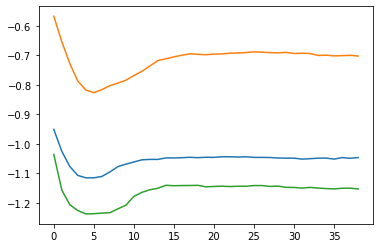

In [25]:
plt.plot(shapelets.T)